패키지 임포트

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer

데이터 로드

In [3]:
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

데이터 전처리

In [4]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]


결측치 처리(knn 활용)

- train 결측치 처리

In [5]:
# # KNNImputer 객체를 생성하고 K-Nearest Neighbors 알고리즘으로 결측치 처리 수행
# imputer = KNNImputer()
# imputed_array = imputer.fit_transform(train)

# # KNN 처리된 데이터를 새로운 데이터프레임에 저장
# df_knn_train = pd.DataFrame(imputed_array, columns=train.columns)
# # CSV 파일로 저장
# df_knn_train.to_csv("train_knn_result.csv", index=False)

- test 결측치 처리 

In [6]:
# # KNNImputer 객체를 생성하고 K-Nearest Neighbors 알고리즘으로 결측치 처리 수행
# imputer = KNNImputer()
# imputed_array = imputer.fit_transform(test)

# # KNN 처리된 데이터를 새로운 데이터프레임에 저장
# df_knn_test = pd.DataFrame(imputed_array, columns=test.columns)

# # CSV 파일로 저장
# df_knn_test.to_csv("train_knn_result.csv", index=False)



In [7]:
df_knn_train = pd.read_csv('knn_train_result.csv')
df_knn_test = pd.read_csv('knn_test_result.csv')

모델 학습 및 특성 중요도 확인

Model Tune for LGBM (Imputed).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 26
[LightGBM] [Info] Start training from score 61.940835


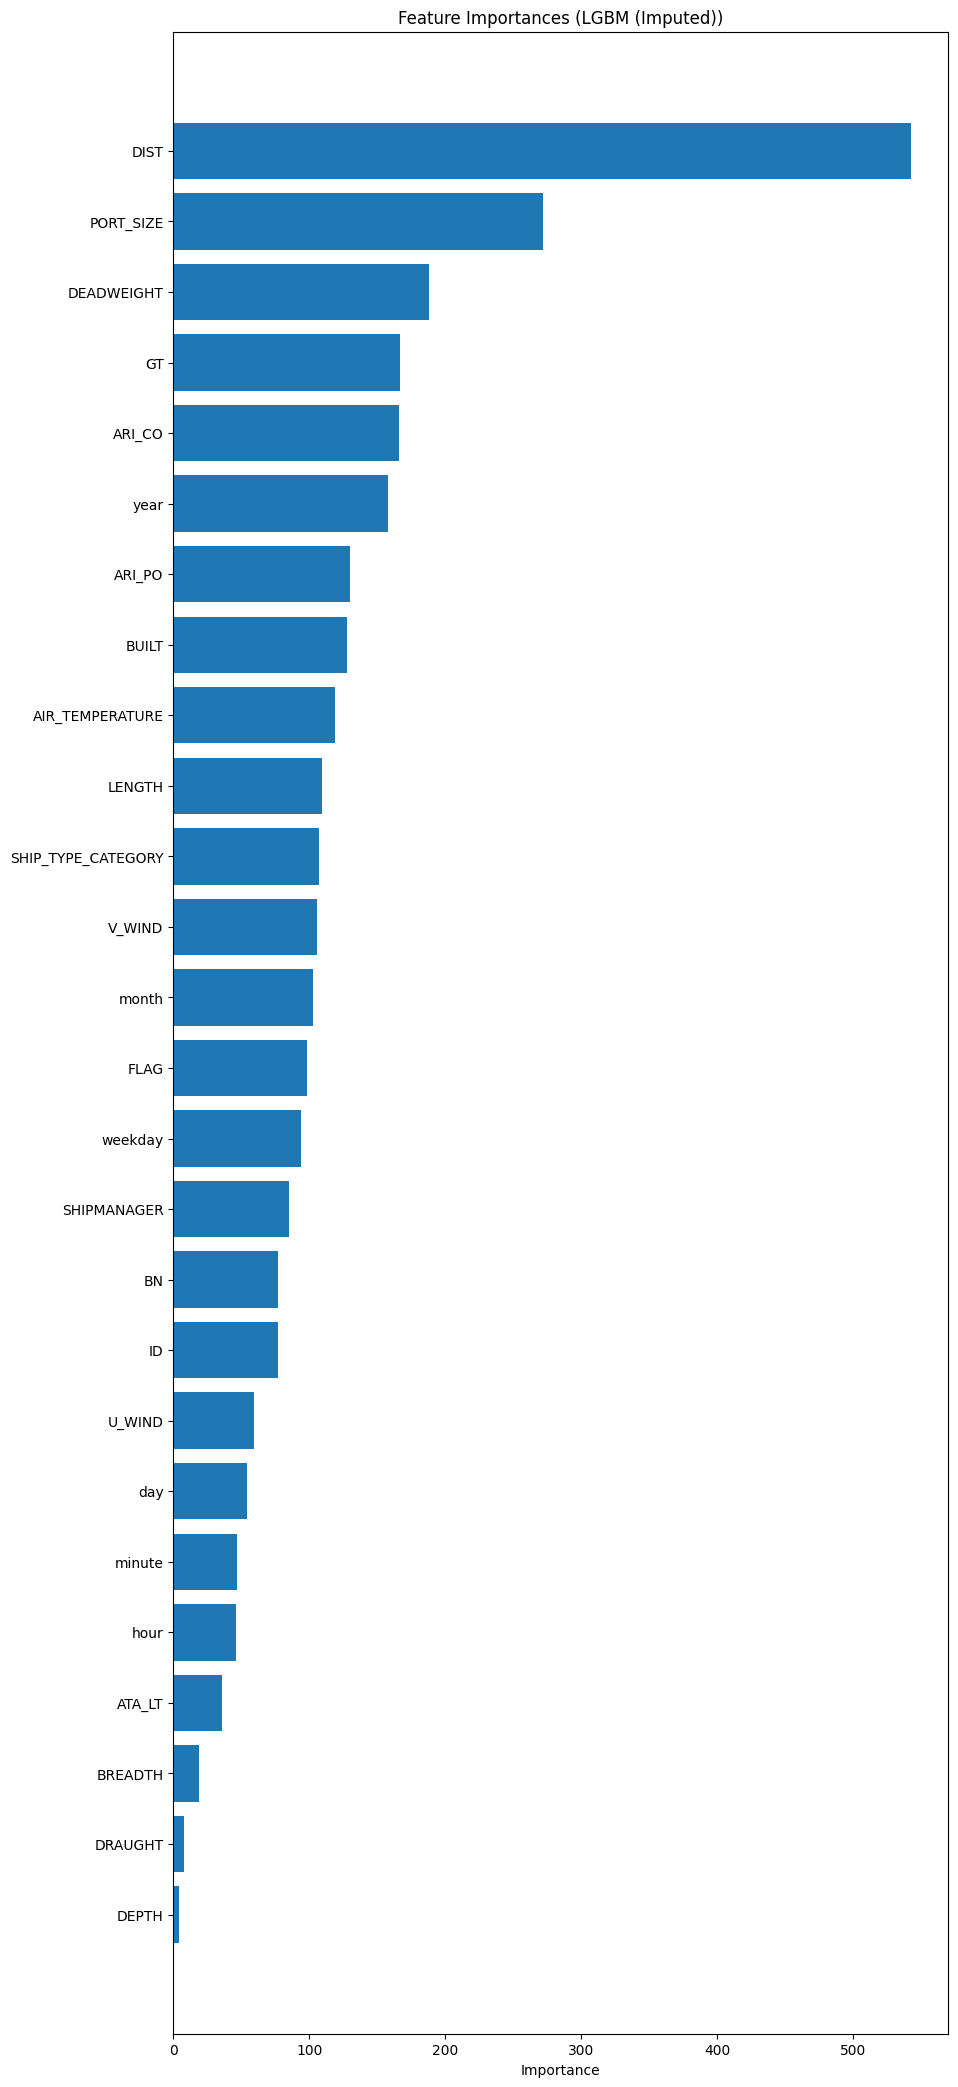

In [8]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = df_knn_train.drop(columns='CI_HOUR')
y_train = df_knn_train['CI_HOUR']

# Model Tune for LGBM on Imputed Data
lgbm_model_imputed, lgbm_feature_importances_imputed = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM (Imputed)', X_train, y_train)

특성 중요도로부터 특성 선택

In [9]:
threshold = 85  # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances_imputed < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = df_knn_test.drop(columns=low_importance_features)

In [10]:
missing_columns = set(X_train.columns) - set(X_train_reduced.columns)
print(missing_columns)

{'hour', 'U_WIND', 'ATA_LT', 'BN', 'minute', 'day', 'DRAUGHT', 'DEPTH', 'BREADTH', 'ID'}


K-FOLD 모델 피팅 및 확인

In [11]:
# LGBM 모델 파라미터 설정
lgbm_params = {
    'num_leaves': 100,
    'learning_rate': 0.27,
    'max_depth': 13,
    'n_estimators': 1100,
    'min_child_samples': 15,
    'min_split_gain': 0.0,
    'min_child_weight': 0,
    'subsample_freq': 0,
    'subsample_for_bin': 200000,
    'subsample': 0.01,
    'objective': 'regression_l1',
    'alpha': 0.000025,
    'lambda_l1': 0.097,
    'lambda_l2': 0.5,
    'feature_fraction': 0.98,
    'bagging_fraction': 0.001,
    'max_bin': 800,
    'min_data_in_leaf': 45,
    'boosting_type': 'gbdt',
    'min_gain_to_split': 0.0063,
    'min_sum_hessian_in_leaf': 0.01,
    'max_cat_threshold': 36,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'max_delta_step': 0,
    'max_cat_group': 64,
    'force_row_wise': True,
    'neg_bagging_fraction': 1.0,
    'pos_bagging_fraction': 0.01,
    'metric': 'mae',
    'reg_sqrt': False,
    'fair_c': 0.1,
    'is_enable_sparse': True,
    'extra_trees': False,
    'max_drop': 50,
    'num_grad_quant_bins': 4,
    'verbosity': 0,
    'top_k': 20
}
# LightGBM 모델 생성
lgbm = lgb.LGBMRegressor(**lgbm_params)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in kf.split(X_train_reduced):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # LightGBM 모델 학습
    lgbm.fit(X_t, y_t)

    # Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=15 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] feature_fraction is set=0.98, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.98
[LightGBM] [Warning] min_gain_to_split is set=0.0063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0063
[LightGBM] [Warning] lambda_l1 is set=0.097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.097
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.01, min_child_weight=0 will be ignored. Current value: min_sum_hessian_in_leaf=0.01
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=0.001, subsample=0.01 will be ignored. Current value: bagging_fraction=0.001
[LightGBM] [Warning] Unknown parameter: max_cat_group
[LightGBM] [Warning] min_data_in_leaf is se

예측 결과 csv 파일 저장

In [12]:
# # 예측 결과를 저장한 submit 데이터프레임 생성
# submit = pd.read_csv('./sample_submission.csv')
# submit['CI_HOUR'] = final_predictions

# # 결과를 CSV 파일로 저장
# submit.to_csv('./KNN_LGBM_submit.csv', index=False)


# CI_HOUR 비교 

- train데이터의 CI_HOUR 그래프

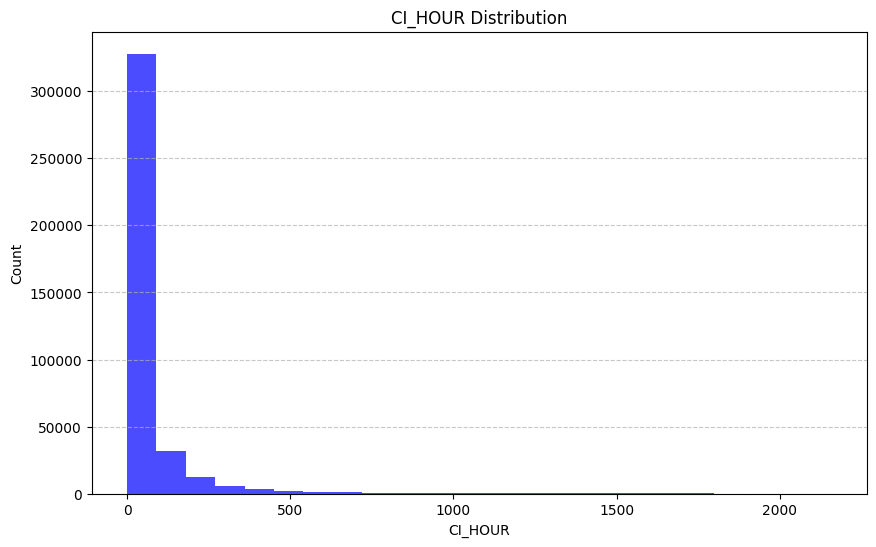

In [13]:
# Train 데이터의 CI_HOUR 열의 값 가져오기
ci_hour_values = df_knn_train['CI_HOUR']

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(ci_hour_values, bins=24, alpha=0.7, color='blue')
plt.title('CI_HOUR Distribution')
plt.xlabel('CI_HOUR')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 보여주기
plt.show()

- 예측된 CI_HOUR 그래프

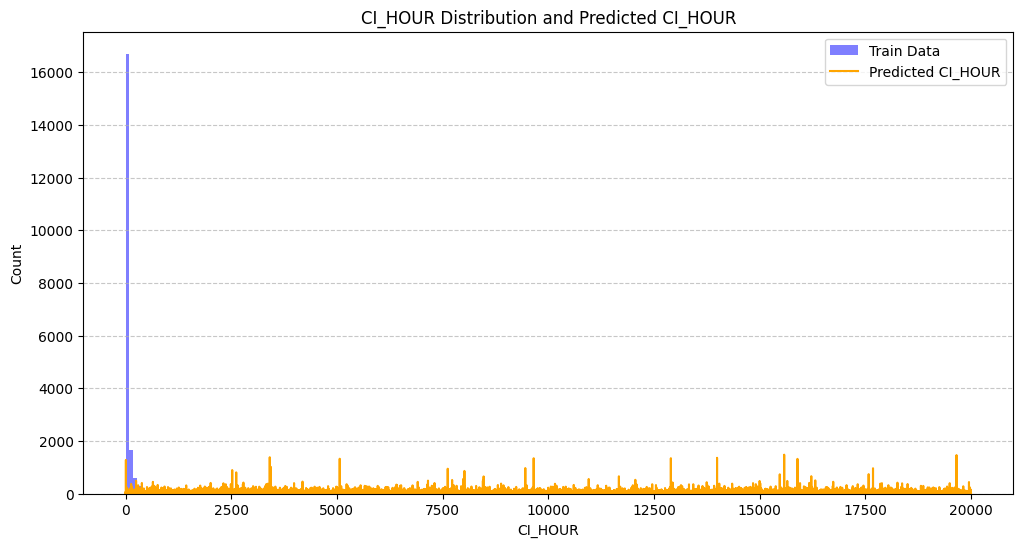

In [19]:
# Train 데이터의 CI_HOUR 열의 값 가져오기
ci_hour_values = df_knn_train['CI_HOUR']

# 예측한 CI_HOUR 그래프
plt.figure(figsize=(12, 6))

# Train 데이터의 CI_HOUR 히스토그램
plt.hist(ci_hour_values[:20000], bins=24, alpha=0.5, color='blue', label='Train Data')
plt.plot(final_predictions[:20000], label='Predicted CI_HOUR', color='orange')
plt.title('CI_HOUR Distribution and Predicted CI_HOUR')
plt.xlabel('CI_HOUR')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

- 두 그래프 비교 

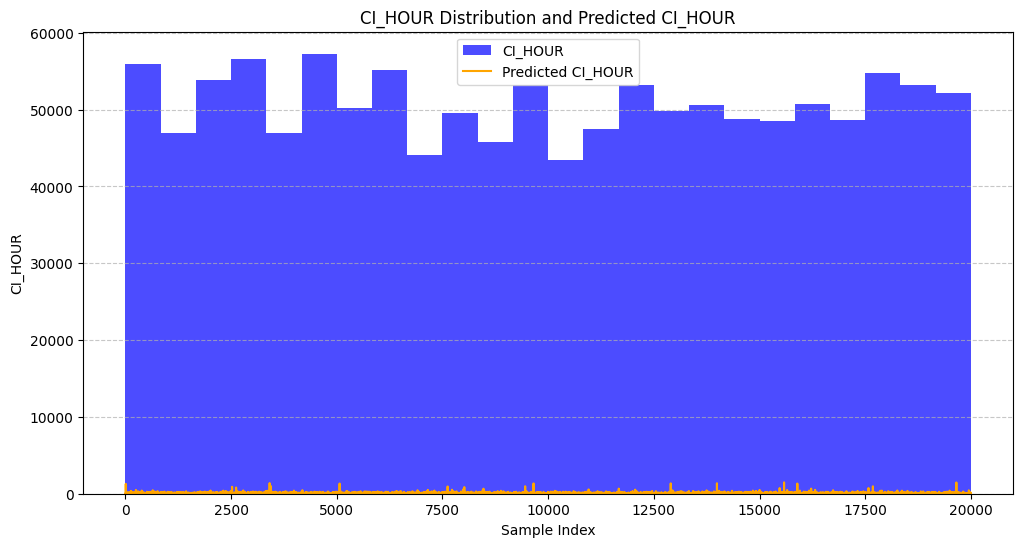

In [15]:
# Train 데이터의 CI_HOUR 열의 값 가져오기
ci_hour_values = df_knn_train['CI_HOUR'][:20000]

# final_predictions 역시 20000개까지만 사용
final_predictions = final_predictions[:20000]

# 히스토그램 그리기
plt.figure(figsize=(12, 6))
plt.hist(range(len(ci_hour_values)), bins=24, weights=ci_hour_values, alpha=0.7, color='blue', label='CI_HOUR')
plt.plot(final_predictions, label='Predicted CI_HOUR', color='orange')
plt.title('CI_HOUR Distribution and Predicted CI_HOUR')
plt.xlabel('Sample Index')
plt.ylabel('CI_HOUR')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()